# 🔥 Automatic Differentiation: How Gradients Compute Themselves

---

## The Mystery We're Solving

You write this in PyTorch:

```python
loss = model(x)
loss.backward()  # ← Magic happens here
```

And suddenly, **every parameter** in your million-parameter network has a gradient.

**How?!**

This notebook demystifies automatic differentiation — the engine behind modern deep learning.

---

## 📚 What You'll Learn

| Section | Question Answered |
|---------|------------------|
| **Part 1** | Why can't we just compute gradients by hand or numerically? |
| **Part 2** | What exactly IS numerical differentiation and why does it fail? |
| **Part 3** | How is autodiff fundamentally different? |
| **Part 4** | What is a computational graph? |
| **Part 5** | How does the chain rule flow backward? |
| **Part 6** | Can we build a mini autograd from scratch? |
| **Part 7** | How do PyTorch, TensorFlow, and JAX do it? |

---

In [1]:
# ============================================================
# SETUP
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import time

# Check if PyTorch is available
try:
    import torch
    TORCH_AVAILABLE = True
    print("✅ PyTorch available:", torch.__version__)
except ImportError:
    TORCH_AVAILABLE = False
    print("⚠️ PyTorch not installed. Run: pip install torch")

# Check if torchviz is available
try:
    from torchviz import make_dot
    TORCHVIZ_AVAILABLE = True
    print("✅ torchviz available")
except ImportError:
    TORCHVIZ_AVAILABLE = False
    print("⚠️ torchviz not installed. Run: pip install torchviz")

# Check if graphviz is available
try:
    from graphviz import Digraph
    GRAPHVIZ_AVAILABLE = True
    print("✅ graphviz available")
except ImportError:
    GRAPHVIZ_AVAILABLE = False
    print("⚠️ graphviz not installed. Run: pip install graphviz")

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams['font.size'] = 11

np.random.seed(42)
print("\n✅ Setup complete!")


✅ PyTorch available: 2.9.1+cpu
✅ torchviz available
✅ graphviz available

✅ Setup complete!


---

# Part 1: The Problem — Why We Need Autodiff

---

## 1.1 Manual Gradients Don't Scale

For simple functions, we can derive gradients by hand:

$$L(\theta) = \theta^2 \quad \Rightarrow \quad \frac{\partial L}{\partial \theta} = 2\theta$$

Easy! But now consider a **real neural network**:

```
┌─────────────────────────────────────────────────────────────────────┐
│  A SMALL Neural Network (MNIST classifier)                         │
├─────────────────────────────────────────────────────────────────────┤
│  Layer 1: h₁ = ReLU(W₁·x + b₁)      →  784 × 256 = 200,704 weights │
│  Layer 2: h₂ = ReLU(W₂·h₁ + b₂)     →  256 × 128 =  32,768 weights │
│  Layer 3: h₃ = ReLU(W₃·h₂ + b₃)     →  128 × 64  =   8,192 weights │
│  Output:  ŷ  = Softmax(W₄·h₃ + b₄)  →   64 × 10  =     640 weights │
│                                                                     │
│  TOTAL: ~242,000 parameters                                         │
│                                                                     │
│  You need ∂L/∂θᵢ for ALL 242,000 parameters!                        │
└─────────────────────────────────────────────────────────────────────┘
```

And this is **small**! Modern language models have **billions** of parameters.

| Model | Parameters | Manual Derivatives? |
|-------|-----------|--------------------|
| MNIST MLP | 242,000 | 😰 Very painful |
| ResNet-50 | 25,000,000 | 🚫 Impossible |
| GPT-3 | 175,000,000,000 | 🤯 Absolutely not |

---

## 1.2 The Three Options

How can we compute gradients for complex functions?

| Method | Approach | Speed | Accuracy | Scales? |
|--------|----------|-------|----------|--------|
| **Symbolic** | Algebra rules (like Wolfram Alpha) | N/A | Exact formula | ❌ Expression explosion |
| **Numerical** | Wiggle input, measure output change | 🐌 Slow | ≈ Approximate | ❌ O(N) function calls |
| **Automatic** | Chain rule on computation graph | 🚀 Fast | ✓ Exact | ✅ O(1) backward pass |

### Common Misconception 🚨

> **WRONG:** "Autodiff is just numerical differentiation done faster by the computer"

> **RIGHT:** Autodiff computes **exact** derivatives using the chain rule — no approximation!

This distinction is **crucial**. Let's understand why numerical differentiation fails.

---

---

# Part 2: Numerical Differentiation — What It Is & Why It Fails

---

## 2.1 The Basic Idea

Remember the definition of a derivative from calculus:

$$f'(x) = \lim_{h \to 0} \frac{f(x + h) - f(x)}{h}$$

Numerical differentiation says: *"Let's just use a small h instead of the limit!"*

$$f'(x) \approx \frac{f(x + h) - f(x)}{h}$$

### A Concrete Example

Let's compute the derivative of $f(x) = x^2$ at $x = 3$.

**True answer:** $f'(x) = 2x$, so $f'(3) = 6$

**Numerical approximation:**

In [2]:
# ============================================================
# DEMONSTRATION: Numerical differentiation basics
# ============================================================

def f(x):
    return x ** 2

x = 3.0
true_derivative = 2 * x  # We know f'(x) = 2x

print("Function: f(x) = x²")
print(f"Point: x = {x}")
print(f"True derivative: f'({x}) = {true_derivative}")
print("\n" + "="*60)
print("NUMERICAL APPROXIMATION: f'(x) ≈ [f(x+h) - f(x)] / h")
print("="*60 + "\n")

for h in [1.0, 0.1, 0.01, 0.001]:
    numerical_derivative = (f(x + h) - f(x)) / h
    error = abs(numerical_derivative - true_derivative)
    
    print(f"h = {h:<8} → f'(3) ≈ {numerical_derivative:<10.6f} → Error: {error:.6f}")

print("\n📌 Observation: Smaller h → Better approximation (so far...)")

Function: f(x) = x²
Point: x = 3.0
True derivative: f'(3.0) = 6.0

NUMERICAL APPROXIMATION: f'(x) ≈ [f(x+h) - f(x)] / h

h = 1.0      → f'(3) ≈ 7.000000   → Error: 1.000000
h = 0.1      → f'(3) ≈ 6.100000   → Error: 0.100000
h = 0.01     → f'(3) ≈ 6.010000   → Error: 0.010000
h = 0.001    → f'(3) ≈ 6.001000   → Error: 0.001000

📌 Observation: Smaller h → Better approximation (so far...)


## 2.2 The Goldilocks Problem: h Can't Be Too Small Either!

You might think: *"Just use h = 0.0000000001 and get a perfect answer!"*

**Wrong!** Computers use floating-point arithmetic, which has limited precision.

When h gets too small:
- $f(x + h) \approx f(x)$ due to rounding
- You're dividing tiny noise by tiny h
- **Catastrophic cancellation** occurs!

Let's see this happen:

In [3]:
# ============================================================
# DEMONSTRATION: The h dilemma — too big AND too small are bad
# ============================================================

def f(x):
    return x ** 3 + 2 * x ** 2 - 5 * x + 3

def true_derivative(x):
    return 3 * x ** 2 + 4 * x - 5  # Analytical derivative

x = 2.0
true_grad = true_derivative(x)  # = 15.0

print("Function: f(x) = x³ + 2x² - 5x + 3")
print(f"True derivative at x=2: f'(2) = {true_grad}")
print("\n" + "="*70)
print(f"{'h':<12} {'Numerical f`(2)':<20} {'Error':<15} {'Status'}")
print("="*70)

h_values = [1e-1, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12, 1e-14, 1e-15]
errors = []

for h in h_values:
    numerical_grad = (f(x + h) - f(x)) / h
    error = abs(numerical_grad - true_grad)
    errors.append(error)
    
    # Determine status
    if error > 0.1:
        status = "❌ Too large h"
    elif error < 1e-6:
        status = "✅ Sweet spot"
    elif h < 1e-12:
        status = "💥 Floating point disaster!"
    else:
        status = "⚠️ Getting worse"
    
    print(f"{h:<12.0e} {numerical_grad:<20.10f} {error:<15.2e} {status}")

print("\n" + "="*70)
print("📌 THE GOLDILOCKS PROBLEM:")
print("   • h too large → Bad approximation (truncation error)")
print("   • h too small → Floating point errors (round-off error)")
print("   • Just right  → A narrow sweet spot that's hard to find!")

Function: f(x) = x³ + 2x² - 5x + 3
True derivative at x=2: f'(2) = 15.0

h            Numerical f`(2)      Error           Status
1e-01        15.8100000000        8.10e-01        ❌ Too large h
1e-02        15.0801000000        8.01e-02        ⚠️ Getting worse
1e-04        15.0008000100        8.00e-04        ⚠️ Getting worse
1e-06        15.0000080019        8.00e-06        ⚠️ Getting worse
1e-08        14.9999998200        1.80e-07        ✅ Sweet spot
1e-10        15.0000012411        1.24e-06        ⚠️ Getting worse
1e-12        15.0013335087        1.33e-03        ⚠️ Getting worse
1e-14        15.4543045028        4.54e-01        ❌ Too large h
1e-15        14.2108547152        7.89e-01        ❌ Too large h

📌 THE GOLDILOCKS PROBLEM:
   • h too large → Bad approximation (truncation error)
   • h too small → Floating point errors (round-off error)
   • Just right  → A narrow sweet spot that's hard to find!


C:\Users\maxgn\AppData\Local\Temp\ipykernel_32648\4177192955.py:30: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\maxgn\Digital Assets Trading\assignment5_1_starter\project_assignment_5_1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


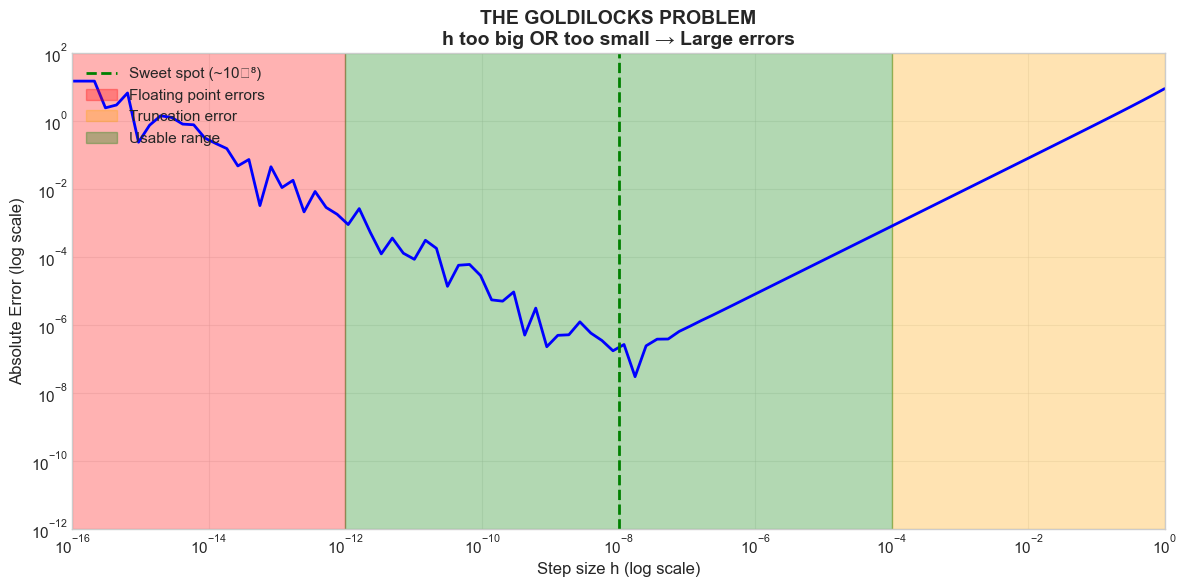


📌 KEY INSIGHT:
   There's only a narrow range of h values that give good results.
   And this range changes for different functions and x values!


In [4]:
# ============================================================
# VISUALIZATION: The h dilemma
# ============================================================

h_range = np.logspace(-16, 0, 100)
errors_plot = []

for h in h_range:
    numerical = (f(x + h) - f(x)) / h
    errors_plot.append(abs(numerical - true_grad))

fig, ax = plt.subplots(figsize=(12, 6))

ax.loglog(h_range, errors_plot, 'b-', linewidth=2)
ax.axvline(x=1e-8, color='green', linestyle='--', linewidth=2, label='Sweet spot (~10⁻⁸)')

# Annotate regions
ax.fill_betweenx([1e-12, 1e2], 1e-16, 1e-12, alpha=0.3, color='red', label='Floating point errors')
ax.fill_betweenx([1e-12, 1e2], 1e-4, 1, alpha=0.3, color='orange', label='Truncation error')
ax.fill_betweenx([1e-12, 1e2], 1e-12, 1e-4, alpha=0.3, color='green', label='Usable range')

ax.set_xlabel('Step size h (log scale)', fontsize=12)
ax.set_ylabel('Absolute Error (log scale)', fontsize=12)
ax.set_title('THE GOLDILOCKS PROBLEM\nh too big OR too small → Large errors', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.set_xlim(1e-16, 1)
ax.set_ylim(1e-12, 1e2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📌 KEY INSIGHT:")
print("   There's only a narrow range of h values that give good results.")
print("   And this range changes for different functions and x values!")

## 2.3 The Fatal Flaw: Numerical Diff Doesn't Scale

Even if we could find the perfect h, numerical differentiation has a **fatal scaling problem**.

### The Cost Analysis

To compute $\frac{\partial L}{\partial \theta_i}$ for parameter $\theta_i$:

$$\frac{\partial L}{\partial \theta_i} \approx \frac{L(\theta_1, ..., \theta_i + h, ..., \theta_n) - L(\theta)}{h}$$

We must:
1. Compute $L(\theta)$ — the baseline (1 forward pass)
2. For **each** of N parameters:
   - Perturb that parameter by h
   - Compute the loss again (another forward pass)

**Total: N + 1 forward passes!**

In [5]:
# ============================================================
# THE SCALING CATASTROPHE
# ============================================================

print("="*75)
print("THE SCALING CATASTROPHE: Numerical Differentiation")
print("="*75)
print("\nTo get ALL gradients numerically, we need N+1 forward passes.\n")

models = [
    ("Simple MLP (MNIST)", 242_000, 0.001),
    ("ResNet-50", 25_000_000, 0.05),
    ("BERT-Base", 110_000_000, 0.1),
    ("GPT-2", 1_500_000_000, 0.5),
    ("GPT-3", 175_000_000_000, 2.0),
]

print(f"{'Model':<25} {'Parameters':<20} {'Forward Passes':<20} {'Time (if 1 pass = X sec)'}")
print("-"*90)

for name, params, time_per_pass in models:
    forward_passes = params + 1
    total_seconds = forward_passes * time_per_pass
    
    # Convert to human-readable time
    if total_seconds < 60:
        time_str = f"{total_seconds:.0f} seconds"
    elif total_seconds < 3600:
        time_str = f"{total_seconds/60:.0f} minutes"
    elif total_seconds < 86400:
        time_str = f"{total_seconds/3600:.1f} hours"
    elif total_seconds < 86400 * 365:
        time_str = f"{total_seconds/86400:.0f} days"
    else:
        time_str = f"{total_seconds/(86400*365):.0f} YEARS"
    
    print(f"{name:<25} {params:>15,}     {forward_passes:>15,}     {time_str}")

print("\n" + "="*75)
print("💀 VERDICT: Numerical differentiation is COMPLETELY IMPRACTICAL")
print("            for neural networks. We need something fundamentally different.")
print("="*75)

THE SCALING CATASTROPHE: Numerical Differentiation

To get ALL gradients numerically, we need N+1 forward passes.

Model                     Parameters           Forward Passes       Time (if 1 pass = X sec)
------------------------------------------------------------------------------------------
Simple MLP (MNIST)                242,000             242,001     4 minutes
ResNet-50                      25,000,000          25,000,001     14 days
BERT-Base                     110,000,000         110,000,001     127 days
GPT-2                       1,500,000,000       1,500,000,001     24 YEARS
GPT-3                     175,000,000,000     175,000,000,001     11098 YEARS

💀 VERDICT: Numerical differentiation is COMPLETELY IMPRACTICAL
            for neural networks. We need something fundamentally different.


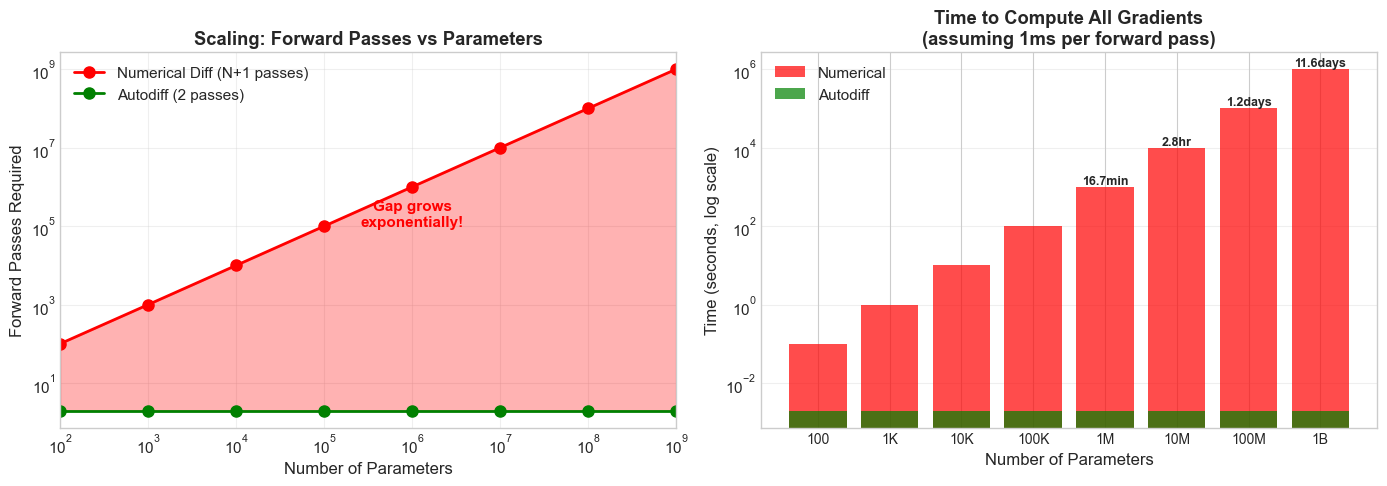


💡 THIS IS WHY DEEP LEARNING EXISTS!

Without autodiff, training a 1M parameter network would take ~17 minutes
PER GRADIENT UPDATE. With autodiff, it takes ~2 milliseconds.

That's a 500,000x speedup. Neural networks would be impossible without this.


In [6]:
# ============================================================
# VISUALIZATION: Numerical vs Autodiff Scaling
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Data for comparison
n_params = [1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]
numerical_passes = [n + 1 for n in n_params]  # N+1 forward passes
autodiff_passes = [2] * len(n_params)  # Always just 2 (forward + backward)

# Plot 1: Number of passes
ax1 = axes[0]
ax1.loglog(n_params, numerical_passes, 'ro-', linewidth=2, markersize=8, label='Numerical Diff (N+1 passes)')
ax1.loglog(n_params, autodiff_passes, 'go-', linewidth=2, markersize=8, label='Autodiff (2 passes)')
ax1.fill_between(n_params, numerical_passes, autodiff_passes, alpha=0.3, color='red')
ax1.set_xlabel('Number of Parameters', fontsize=12)
ax1.set_ylabel('Forward Passes Required', fontsize=12)
ax1.set_title('Scaling: Forward Passes vs Parameters', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1e2, 1e9)

# Add annotation
ax1.annotate('Gap grows\nexponentially!', xy=(1e6, 1e5), fontsize=11, 
             ha='center', color='red', fontweight='bold')

# Plot 2: Time comparison (assuming 1ms per forward pass)
ax2 = axes[1]
time_per_pass_ms = 1  # 1 millisecond per forward pass
numerical_time_sec = [n * time_per_pass_ms / 1000 for n in numerical_passes]
autodiff_time_sec = [2 * time_per_pass_ms / 1000] * len(n_params)

# Convert to readable units
def format_time(seconds):
    if seconds < 1:
        return f"{seconds*1000:.0f}ms"
    elif seconds < 60:
        return f"{seconds:.1f}s"
    elif seconds < 3600:
        return f"{seconds/60:.1f}min"
    elif seconds < 86400:
        return f"{seconds/3600:.1f}hr"
    else:
        return f"{seconds/86400:.1f}days"

bars = ax2.bar(range(len(n_params)), numerical_time_sec, alpha=0.7, color='red', label='Numerical')
ax2.bar(range(len(n_params)), autodiff_time_sec, alpha=0.7, color='green', label='Autodiff')
ax2.set_xticks(range(len(n_params)))
ax2.set_xticklabels(['100', '1K', '10K', '100K', '1M', '10M', '100M', '1B'], fontsize=10)
ax2.set_xlabel('Number of Parameters', fontsize=12)
ax2.set_ylabel('Time (seconds, log scale)', fontsize=12)
ax2.set_title('Time to Compute All Gradients\n(assuming 1ms per forward pass)', fontweight='bold')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add time labels on bars
for i, (bar, t) in enumerate(zip(bars, numerical_time_sec)):
    if i >= 4:  # Only label the big ones
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                format_time(t), ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("💡 THIS IS WHY DEEP LEARNING EXISTS!")
print("="*70)
print("\nWithout autodiff, training a 1M parameter network would take ~17 minutes")
print("PER GRADIENT UPDATE. With autodiff, it takes ~2 milliseconds.")
print("\nThat's a 500,000x speedup. Neural networks would be impossible without this.")

## 2.4 Summary: Why Numerical Differentiation Fails

| Problem | Description | Impact |
|---------|-------------|--------|
| **Accuracy** | Approximation errors from finite h | Results are never exact |
| **Instability** | h too small → floating point disaster | Hard to choose h |
| **Speed** | Need N+1 forward passes for N parameters | Minutes → Years for large models |

```
┌─────────────────────────────────────────────────────────────────────┐
│                                                                     │
│   NUMERICAL DIFFERENTIATION:                                        │
│                                                                     │
│   "I have NO IDEA what happens inside f(x).                         │
│    So I'll poke the input and watch the output wiggle."             │
│                                                                     │
│            ┌─────────────┐                                          │
│    θ + h ──│             │                                          │
│            │  BLACK BOX  │──► Loss + ε                              │
│    θ     ──│    f(θ)     │──► Loss                                  │
│            │             │                                          │
│            └─────────────┘                                          │
│                                                                     │
│   Must poke EACH parameter separately = N+1 evaluations!            │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

**We need a method that looks INSIDE the function.**

---

---

# Part 3: The Autodiff Revolution — Exact and Fast

---

## 3.1 The Key Insight: We Know What's Inside!

Unlike numerical differentiation, which treats f(x) as a **black box**, autodiff **looks inside**.

Every computation is made up of **elementary operations**:
- Addition: $z = x + y$
- Multiplication: $z = x \times y$
- Powers: $z = x^n$
- Trigonometry: $z = \sin(x)$, $\cos(x)$
- Exponentials: $z = e^x$, $\log(x)$

And **we know the derivative of each one**:

| Operation | Derivative |
|-----------|------------|
| $z = x + y$ | $\frac{\partial z}{\partial x} = 1$, $\frac{\partial z}{\partial y} = 1$ |
| $z = x \times y$ | $\frac{\partial z}{\partial x} = y$, $\frac{\partial z}{\partial y} = x$ |
| $z = x^n$ | $\frac{\partial z}{\partial x} = nx^{n-1}$ |
| $z = \sin(x)$ | $\frac{\partial z}{\partial x} = \cos(x)$ |
| $z = e^x$ | $\frac{\partial z}{\partial x} = e^x$ |

### The Autodiff Strategy

1. **Record** every elementary operation as computation happens
2. **Apply the chain rule** in reverse to combine local derivatives
3. Get **exact** gradients with **one backward pass**!

---

## 3.2 The Fundamental Difference (This Is Important!)

```
┌─────────────────────────────────────────────────────────────────────────┐
│                                                                         │
│   NUMERICAL DIFFERENTIATION                                             │
│   ════════════════════════════                                          │
│                                                                         │
│   "I don't know what's inside, so I'll wiggle and measure."             │
│                                                                         │
│          θ₁ ─────?────┐                                                 │
│          θ₂ ─────?────┤                                                 │
│          θ₃ ─────?────┼────►  [ BLACK BOX ]  ────► Loss                 │
│          ...          │            f(θ)                                 │
│          θₙ ─────?────┘                                                 │
│                                                                         │
│   • Must wiggle EACH θᵢ separately, re-run f(θ) each time               │
│   • N parameters → N+1 function evaluations                             │
│   • Result is APPROXIMATE                                               │
│                                                                         │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                         │
│   AUTOMATIC DIFFERENTIATION                                             │
│   ════════════════════════════                                          │
│                                                                         │
│   "I watched every operation. Let me replay the tape in reverse."       │
│                                                                         │
│          θ₁ ──────────┐        ┌──────────────────────┐                 │
│          θ₂ ──────────┤        │   TRANSPARENT BOX    │                 │
│          θ₃ ──────────┼────►   │                      │  ────► Loss     │
│          ...          │        │   z₁ = θ₁ × θ₂      │                 │
│          θₙ ──────────┘        │   z₂ = z₁ + θ₃      │                 │
│                                │   z₃ = sin(z₂)       │                 │
│                                │   ...                │                 │
│                                │   L = final op       │                 │
│                                └──────────────────────┘                 │
│                                           │                             │
│                                           ▼                             │
│                                  Replay tape backward                   │
│                                  Apply chain rule at each step          │
│                                           │                             │
│                                           ▼                             │
│                               ALL gradients at once!                    │
│                                                                         │
│   • One forward pass + one backward pass                                │
│   • N parameters → 2 passes total (regardless of N!)                    │
│   • Result is EXACT (to machine precision)                              │
│                                                                         │
└─────────────────────────────────────────────────────────────────────────┘
```

## 3.3 Head-to-Head Comparison

Let's compute the **same gradient** using both methods and compare:

In [7]:
# ============================================================
# HEAD-TO-HEAD: Numerical vs Autodiff
# ============================================================

# Function: f(x, y, z) = x²y + sin(z) + xy²z
# This is complex enough to be interesting

def f_numpy(x, y, z):
    """Our test function using NumPy"""
    return x**2 * y + np.sin(z) + x * y**2 * z

# True analytical derivatives (we'll verify against these)
def true_df_dx(x, y, z):
    return 2*x*y + y**2 * z

def true_df_dy(x, y, z):
    return x**2 + 2*x*y*z

def true_df_dz(x, y, z):
    return np.cos(z) + x * y**2

# Point to evaluate at
x_val, y_val, z_val = 2.0, 3.0, 1.0

print("="*70)
print("COMPUTING GRADIENTS: f(x,y,z) = x²y + sin(z) + xy²z")
print(f"At point: x={x_val}, y={y_val}, z={z_val}")
print("="*70)

# Ground truth
true_dx = true_df_dx(x_val, y_val, z_val)
true_dy = true_df_dy(x_val, y_val, z_val)
true_dz = true_df_dz(x_val, y_val, z_val)

print(f"\n📐 TRUE GRADIENTS (analytical):")
print(f"   ∂f/∂x = {true_dx:.6f}")
print(f"   ∂f/∂y = {true_dy:.6f}")
print(f"   ∂f/∂z = {true_dz:.6f}")

COMPUTING GRADIENTS: f(x,y,z) = x²y + sin(z) + xy²z
At point: x=2.0, y=3.0, z=1.0

📐 TRUE GRADIENTS (analytical):
   ∂f/∂x = 21.000000
   ∂f/∂y = 16.000000
   ∂f/∂z = 18.540302


In [8]:
# ============================================================
# METHOD 1: NUMERICAL DIFFERENTIATION
# ============================================================

print("\n" + "─"*70)
print("METHOD 1: NUMERICAL DIFFERENTIATION")
print("─"*70)

h = 1e-7  # Step size (in the "sweet spot")

# Count function evaluations
num_evals = 0

start_time = time.time()

# Baseline
f0 = f_numpy(x_val, y_val, z_val)
num_evals += 1

# Perturb x
df_dx_numerical = (f_numpy(x_val + h, y_val, z_val) - f0) / h
num_evals += 1

# Perturb y
df_dy_numerical = (f_numpy(x_val, y_val + h, z_val) - f0) / h
num_evals += 1

# Perturb z
df_dz_numerical = (f_numpy(x_val, y_val, z_val + h) - f0) / h
num_evals += 1

numerical_time = time.time() - start_time

print(f"\n   h = {h}")
print(f"   Function evaluations: {num_evals}")
print(f"   Time: {numerical_time*1000:.4f} ms")
print(f"\n   Results:")
print(f"   ∂f/∂x ≈ {df_dx_numerical:.6f}  (error: {abs(df_dx_numerical - true_dx):.2e})")
print(f"   ∂f/∂y ≈ {df_dy_numerical:.6f}  (error: {abs(df_dy_numerical - true_dy):.2e})")
print(f"   ∂f/∂z ≈ {df_dz_numerical:.6f}  (error: {abs(df_dz_numerical - true_dz):.2e})")


──────────────────────────────────────────────────────────────────────
METHOD 1: NUMERICAL DIFFERENTIATION
──────────────────────────────────────────────────────────────────────

   h = 1e-07
   Function evaluations: 4
   Time: 0.0000 ms

   Results:
   ∂f/∂x ≈ 21.000000  (error: 2.45e-07)
   ∂f/∂y ≈ 16.000000  (error: 1.51e-07)
   ∂f/∂z ≈ 18.540302  (error: 7.02e-08)


In [9]:
# ============================================================
# METHOD 2: AUTOMATIC DIFFERENTIATION (PyTorch)
# ============================================================

print("\n" + "─"*70)
print("METHOD 2: AUTOMATIC DIFFERENTIATION (PyTorch)")
print("─"*70)

if TORCH_AVAILABLE:
    # Create tensors with gradient tracking
    x = torch.tensor(x_val, requires_grad=True)
    y = torch.tensor(y_val, requires_grad=True)
    z = torch.tensor(z_val, requires_grad=True)
    
    start_time = time.time()
    
    # Forward pass (builds computation graph)
    f = x**2 * y + torch.sin(z) + x * y**2 * z
    
    # Backward pass (applies chain rule)
    f.backward()
    
    autodiff_time = time.time() - start_time
    
    print(f"\n   Function evaluations: 1 forward + 1 backward")
    print(f"   Time: {autodiff_time*1000:.4f} ms")
    print(f"\n   Results:")
    print(f"   ∂f/∂x = {x.grad.item():.6f}  (error: {abs(x.grad.item() - true_dx):.2e})")
    print(f"   ∂f/∂y = {y.grad.item():.6f}  (error: {abs(y.grad.item() - true_dy):.2e})")
    print(f"   ∂f/∂z = {z.grad.item():.6f}  (error: {abs(z.grad.item() - true_dz):.2e})")
else:
    print("\n   (PyTorch not available - skipping this demo)")

print("\n" + "="*70)
print("📌 KEY OBSERVATIONS:")
print("="*70)
print("""
   NUMERICAL:
   • Needed 4 function evaluations (baseline + 3 perturbations)
   • Results are APPROXIMATE (small errors)
   • Scales as O(N) with number of parameters
   
   AUTODIFF:
   • Needed 1 forward + 1 backward pass
   • Results are EXACT (to machine precision)
   • Scales as O(1) - same cost regardless of N!
""")


──────────────────────────────────────────────────────────────────────
METHOD 2: AUTOMATIC DIFFERENTIATION (PyTorch)
──────────────────────────────────────────────────────────────────────

   Function evaluations: 1 forward + 1 backward
   Time: 1.0026 ms

   Results:
   ∂f/∂x = 21.000000  (error: 0.00e+00)
   ∂f/∂y = 16.000000  (error: 0.00e+00)
   ∂f/∂z = 18.540302  (error: 2.93e-08)

📌 KEY OBSERVATIONS:

   NUMERICAL:
   • Needed 4 function evaluations (baseline + 3 perturbations)
   • Results are APPROXIMATE (small errors)
   • Scales as O(N) with number of parameters

   AUTODIFF:
   • Needed 1 forward + 1 backward pass
   • Results are EXACT (to machine precision)
   • Scales as O(1) - same cost regardless of N!



---

# Part 4: The Computational Graph

---

## 4.1 Every Computation Is a Graph

The secret to autodiff is viewing computation as a **directed acyclic graph (DAG)**.

### Example: $L = (a + b) \times (c + d)$

```
    INPUTS           OPERATIONS           OUTPUT
    ══════           ══════════           ══════
    
      a ───┐
           ├───► [+] ───► e ───┐
      b ───┘                   │
                               ├───► [×] ───► L
      c ───┐                   │
           ├───► [+] ───► f ───┘
      d ───┘
      
      
    Where:
      e = a + b
      f = c + d  
      L = e × f
```

Each node stores:
1. Its **value** (computed in forward pass)
2. Its **local derivatives** (how output changes w.r.t. inputs)
3. Pointers to its **input nodes**

In [10]:
# ============================================================
# VISUALIZATION: Building a computation graph by hand
# ============================================================

print("="*70)
print("EXAMPLE: Building the graph for L = (a + b) × (c + d)")
print("="*70)

# Values
a, b, c, d = 2.0, 3.0, 4.0, 5.0

print(f"\n📥 INPUTS: a={a}, b={b}, c={c}, d={d}")
print("\n" + "─"*70)
print("FORWARD PASS (compute values, build graph)")
print("─"*70)

# Step 1
e = a + b
print(f"\n  Step 1: e = a + b = {a} + {b} = {e}")
print(f"          Local derivatives: ∂e/∂a = 1, ∂e/∂b = 1")

# Step 2  
f = c + d
print(f"\n  Step 2: f = c + d = {c} + {d} = {f}")
print(f"          Local derivatives: ∂f/∂c = 1, ∂f/∂d = 1")

# Step 3
L = e * f
print(f"\n  Step 3: L = e × f = {e} × {f} = {L}")
print(f"          Local derivatives: ∂L/∂e = f = {f}, ∂L/∂f = e = {e}")

print(f"\n📤 OUTPUT: L = {L}")

EXAMPLE: Building the graph for L = (a + b) × (c + d)

📥 INPUTS: a=2.0, b=3.0, c=4.0, d=5.0

──────────────────────────────────────────────────────────────────────
FORWARD PASS (compute values, build graph)
──────────────────────────────────────────────────────────────────────

  Step 1: e = a + b = 2.0 + 3.0 = 5.0
          Local derivatives: ∂e/∂a = 1, ∂e/∂b = 1

  Step 2: f = c + d = 4.0 + 5.0 = 9.0
          Local derivatives: ∂f/∂c = 1, ∂f/∂d = 1

  Step 3: L = e × f = 5.0 × 9.0 = 45.0
          Local derivatives: ∂L/∂e = f = 9.0, ∂L/∂f = e = 5.0

📤 OUTPUT: L = 45.0


## 4.2 The Backward Pass: Chain Rule in Action

Now we **reverse** through the graph, applying the chain rule at each step.

### The Chain Rule

If $L$ depends on $x$ through intermediate variable $z$:

$$\frac{\partial L}{\partial x} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial x}$$

We call $\frac{\partial L}{\partial z}$ the **upstream gradient** (coming from above in the graph).

In [11]:
# ============================================================
# BACKWARD PASS: Tracing through step by step
# ============================================================

print("\n" + "─"*70)
print("BACKWARD PASS (apply chain rule, compute gradients)")
print("─"*70)

# Start at the output
dL_dL = 1.0
print(f"\n  Start: ∂L/∂L = {dL_dL} (by definition)")

print("\n  " + "─"*60)
print("  Step 3 (backward): L = e × f")
print("  " + "─"*60)

# Gradients of L w.r.t. e and f
dL_de = dL_dL * f  # ∂L/∂e = ∂L/∂L × ∂L/∂e = 1 × f
dL_df = dL_dL * e  # ∂L/∂f = ∂L/∂L × ∂L/∂f = 1 × e

print(f"  ∂L/∂e = ∂L/∂L × ∂L/∂e = {dL_dL} × {f} = {dL_de}")
print(f"  ∂L/∂f = ∂L/∂L × ∂L/∂f = {dL_dL} × {e} = {dL_df}")

print("\n  " + "─"*60)
print("  Step 2 (backward): f = c + d")
print("  " + "─"*60)

# Gradients of L w.r.t. c and d (through f)
dL_dc = dL_df * 1  # ∂L/∂c = ∂L/∂f × ∂f/∂c
dL_dd = dL_df * 1  # ∂L/∂d = ∂L/∂f × ∂f/∂d

print(f"  ∂L/∂c = ∂L/∂f × ∂f/∂c = {dL_df} × 1 = {dL_dc}")
print(f"  ∂L/∂d = ∂L/∂f × ∂f/∂d = {dL_df} × 1 = {dL_dd}")

print("\n  " + "─"*60)
print("  Step 1 (backward): e = a + b")
print("  " + "─"*60)

# Gradients of L w.r.t. a and b (through e)
dL_da = dL_de * 1  # ∂L/∂a = ∂L/∂e × ∂e/∂a
dL_db = dL_de * 1  # ∂L/∂b = ∂L/∂e × ∂e/∂b

print(f"  ∂L/∂a = ∂L/∂e × ∂e/∂a = {dL_de} × 1 = {dL_da}")
print(f"  ∂L/∂b = ∂L/∂e × ∂e/∂b = {dL_de} × 1 = {dL_db}")

print("\n" + "="*70)
print("📊 FINAL GRADIENTS:")
print("="*70)
print(f"  ∂L/∂a = {dL_da}")
print(f"  ∂L/∂b = {dL_db}")
print(f"  ∂L/∂c = {dL_dc}")
print(f"  ∂L/∂d = {dL_dd}")

# Verify
print("\n" + "─"*70)
print("✓ VERIFICATION: L = (a+b)(c+d) = ac + ad + bc + bd")
print("─"*70)
print(f"  ∂L/∂a should be (c+d) = {c+d} ✓" if dL_da == c+d else f"  ∂L/∂a ERROR!")
print(f"  ∂L/∂b should be (c+d) = {c+d} ✓" if dL_db == c+d else f"  ∂L/∂b ERROR!")
print(f"  ∂L/∂c should be (a+b) = {a+b} ✓" if dL_dc == a+b else f"  ∂L/∂c ERROR!")
print(f"  ∂L/∂d should be (a+b) = {a+b} ✓" if dL_dd == a+b else f"  ∂L/∂d ERROR!")


──────────────────────────────────────────────────────────────────────
BACKWARD PASS (apply chain rule, compute gradients)
──────────────────────────────────────────────────────────────────────

  Start: ∂L/∂L = 1.0 (by definition)

  ────────────────────────────────────────────────────────────
  Step 3 (backward): L = e × f
  ────────────────────────────────────────────────────────────
  ∂L/∂e = ∂L/∂L × ∂L/∂e = 1.0 × 9.0 = 9.0
  ∂L/∂f = ∂L/∂L × ∂L/∂f = 1.0 × 5.0 = 5.0

  ────────────────────────────────────────────────────────────
  Step 2 (backward): f = c + d
  ────────────────────────────────────────────────────────────
  ∂L/∂c = ∂L/∂f × ∂f/∂c = 5.0 × 1 = 5.0
  ∂L/∂d = ∂L/∂f × ∂f/∂d = 5.0 × 1 = 5.0

  ────────────────────────────────────────────────────────────
  Step 1 (backward): e = a + b
  ────────────────────────────────────────────────────────────
  ∂L/∂a = ∂L/∂e × ∂e/∂a = 9.0 × 1 = 9.0
  ∂L/∂b = ∂L/∂e × ∂e/∂b = 9.0 × 1 = 9.0

📊 FINAL GRADIENTS:
  ∂L/∂a = 9.0
  ∂L/∂b = 9.0
 

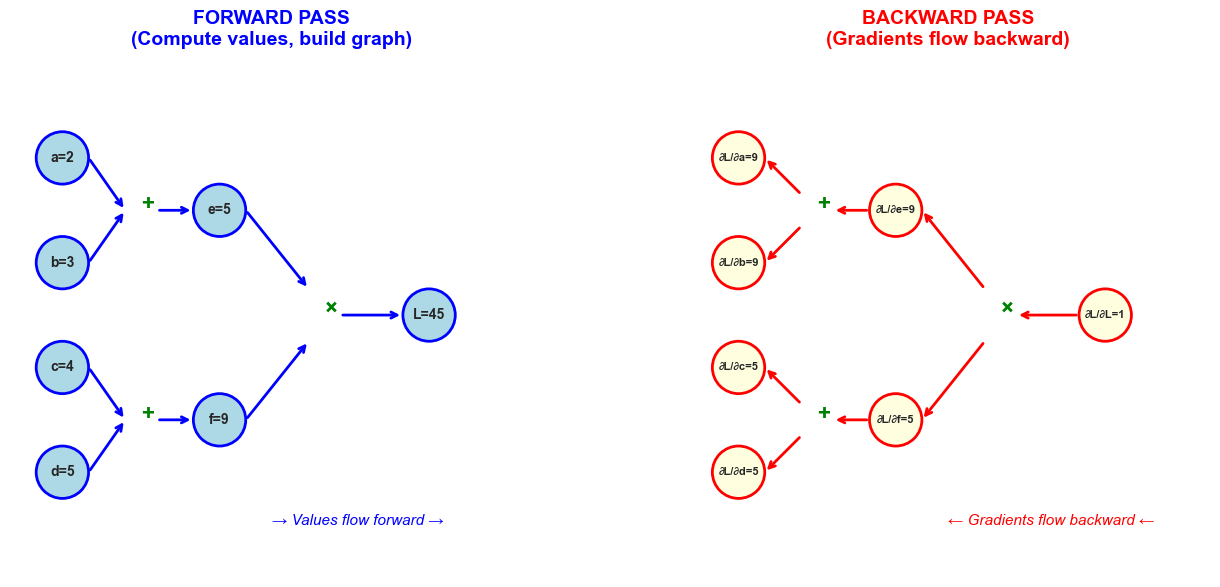


📌 The forward pass computes VALUES (blue).
📌 The backward pass computes GRADIENTS (red) using the chain rule.
📌 All gradients computed in ONE backward pass!


In [12]:
# ============================================================
# VISUALIZATION: Computational Graph (ASCII art rendered)
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Forward pass
ax1 = axes[0]
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)
ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_title('FORWARD PASS\n(Compute values, build graph)', fontsize=14, fontweight='bold', color='blue')

# Nodes
nodes = {
    'a': (1, 8), 'b': (1, 6), 'c': (1, 4), 'd': (1, 2),
    'e': (4, 7), 'f': (4, 3),
    'L': (8, 5)
}
values = {'a': '2', 'b': '3', 'c': '4', 'd': '5', 'e': '5', 'f': '9', 'L': '45'}

# Draw nodes
for name, (x, y) in nodes.items():
    circle = plt.Circle((x, y), 0.5, color='lightblue', ec='blue', linewidth=2)
    ax1.add_patch(circle)
    ax1.text(x, y, f"{name}={values[name]}", ha='center', va='center', fontsize=10, fontweight='bold')

# Draw operations
ax1.text(2.5, 7, '+', fontsize=16, fontweight='bold', color='green')
ax1.text(2.5, 3, '+', fontsize=16, fontweight='bold', color='green')
ax1.text(6, 5, '×', fontsize=16, fontweight='bold', color='green')

# Draw arrows (forward direction)
arrow_style = dict(arrowstyle='->', color='blue', lw=2)
ax1.annotate('', xy=(2.2, 7), xytext=(1.5, 8), arrowprops=arrow_style)
ax1.annotate('', xy=(2.2, 7), xytext=(1.5, 6), arrowprops=arrow_style)
ax1.annotate('', xy=(3.5, 7), xytext=(2.8, 7), arrowprops=arrow_style)

ax1.annotate('', xy=(2.2, 3), xytext=(1.5, 4), arrowprops=arrow_style)
ax1.annotate('', xy=(2.2, 3), xytext=(1.5, 2), arrowprops=arrow_style)
ax1.annotate('', xy=(3.5, 3), xytext=(2.8, 3), arrowprops=arrow_style)

ax1.annotate('', xy=(5.7, 5.5), xytext=(4.5, 7), arrowprops=arrow_style)
ax1.annotate('', xy=(5.7, 4.5), xytext=(4.5, 3), arrowprops=arrow_style)
ax1.annotate('', xy=(7.5, 5), xytext=(6.3, 5), arrowprops=arrow_style)

ax1.text(5, 1, '→ Values flow forward →', fontsize=11, style='italic', color='blue')

# Right: Backward pass
ax2 = axes[1]
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 10)
ax2.set_aspect('equal')
ax2.axis('off')
ax2.set_title('BACKWARD PASS\n(Gradients flow backward)', fontsize=14, fontweight='bold', color='red')

# Same nodes but with gradients
grads = {'a': '9', 'b': '9', 'c': '5', 'd': '5', 'e': '9', 'f': '5', 'L': '1'}

for name, (x, y) in nodes.items():
    circle = plt.Circle((x, y), 0.5, color='lightyellow', ec='red', linewidth=2)
    ax2.add_patch(circle)
    ax2.text(x, y, f"∂L/∂{name}={grads[name]}", ha='center', va='center', fontsize=8, fontweight='bold')

# Draw operations
ax2.text(2.5, 7, '+', fontsize=16, fontweight='bold', color='green')
ax2.text(2.5, 3, '+', fontsize=16, fontweight='bold', color='green')
ax2.text(6, 5, '×', fontsize=16, fontweight='bold', color='green')

# Draw arrows (backward direction - reversed)
arrow_style_back = dict(arrowstyle='->', color='red', lw=2)
ax2.annotate('', xy=(1.5, 8), xytext=(2.2, 7.3), arrowprops=arrow_style_back)
ax2.annotate('', xy=(1.5, 6), xytext=(2.2, 6.7), arrowprops=arrow_style_back)
ax2.annotate('', xy=(2.8, 7), xytext=(3.5, 7), arrowprops=arrow_style_back)

ax2.annotate('', xy=(1.5, 4), xytext=(2.2, 3.3), arrowprops=arrow_style_back)
ax2.annotate('', xy=(1.5, 2), xytext=(2.2, 2.7), arrowprops=arrow_style_back)
ax2.annotate('', xy=(2.8, 3), xytext=(3.5, 3), arrowprops=arrow_style_back)

ax2.annotate('', xy=(4.5, 7), xytext=(5.7, 5.5), arrowprops=arrow_style_back)
ax2.annotate('', xy=(4.5, 3), xytext=(5.7, 4.5), arrowprops=arrow_style_back)
ax2.annotate('', xy=(6.3, 5), xytext=(7.5, 5), arrowprops=arrow_style_back)

ax2.text(5, 1, '← Gradients flow backward ←', fontsize=11, style='italic', color='red')

plt.tight_layout()
plt.show()

print("\n📌 The forward pass computes VALUES (blue).")
print("📌 The backward pass computes GRADIENTS (red) using the chain rule.")
print("📌 All gradients computed in ONE backward pass!")

## 4.3 Visual Summary: Forward and Backward

```
                    FORWARD PASS                      BACKWARD PASS
                  (Compute values)                  (Compute gradients)
                  ════════════════                  ══════════════════
                         
              ┌─────────────────────┐         ┌─────────────────────┐
              │                     │         │                     │
    a=2 ──┐   │   e = a+b = 5       │         │   ∂L/∂a = 9         │   ──► ∂L/∂a
          ├──►│                     │         │   ∂L/∂b = 9         │
    b=3 ──┘   │                     │         │                     │
              │         ↓           │         │         ↑           │
              │   L = e×f = 45      │    ◄────│   ∂L/∂L = 1         │
              │         ↑           │         │         ↓           │
    c=4 ──┐   │                     │         │                     │
          ├──►│   f = c+d = 9       │         │   ∂L/∂c = 5         │   ──► ∂L/∂c
    d=5 ──┘   │                     │         │   ∂L/∂d = 5         │   ──► ∂L/∂d
              │                     │         │                     │
              └─────────────────────┘         └─────────────────────┘
                         
                      ──────►                        ◄──────
                    Values flow                   Gradients flow
                   input → output                output → input
```

---

## 4.4 Visualizing Computation Graphs with Graphviz

We can actually **see** the computation graph that PyTorch builds!

### Installation

```bash
pip install torchviz graphviz
```

You also need Graphviz installed on your system:
- **Windows**: Download from https://graphviz.org/download/ and add to PATH
- **Mac**: `brew install graphviz`
- **Linux**: `sudo apt install graphviz`

In [13]:
# ============================================================
# VISUALIZING PYTORCH COMPUTATION GRAPHS
# ============================================================

# Check if torchviz is available
try:
    from torchviz import make_dot
    TORCHVIZ_AVAILABLE = True
    print("✅ torchviz available")
except ImportError:
    TORCHVIZ_AVAILABLE = False
    print("⚠️ torchviz not installed. Run: pip install torchviz graphviz")
    print("   Also install Graphviz on your system (see markdown above)")

✅ torchviz available


Computation: L = (a + b) × (a - b)
Values: a=2.0, b=3.0, c=5.0, d=-1.0, L=-5.0

📊 Computation Graph:


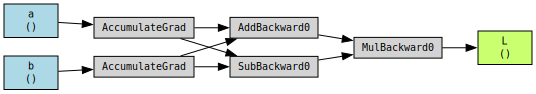

In [14]:
# ============================================================
# EXAMPLE 1: Simple Expression Graph
# ============================================================

if TORCH_AVAILABLE and TORCHVIZ_AVAILABLE:
    # Create a simple computation
    a = torch.tensor(2.0, requires_grad=True)
    b = torch.tensor(3.0, requires_grad=True)
    
    # L = (a + b) * (a - b) = a² - b²
    c = a + b  # 5
    d = a - b  # -1
    L = c * d  # -5
    
    # Visualize the graph
    dot = make_dot(L, params={'a': a, 'b': b, 'c': c, 'd': d, 'L': L})
    dot.attr(rankdir='LR')  # Left to right layout
    
    print("Computation: L = (a + b) × (a - b)")
    print(f"Values: a={a.item()}, b={b.item()}, c={c.item()}, d={d.item()}, L={L.item()}")
    print("\n📊 Computation Graph:")
    display(dot)
else:
    print("Skipping - requires torch and torchviz")

Computation: L = (x² + y) × sin(x) + exp(y/2)
Inputs: x=2.0, y=3.0
Result: L=10.8468

📊 Computation Graph (notice how operations are tracked!):


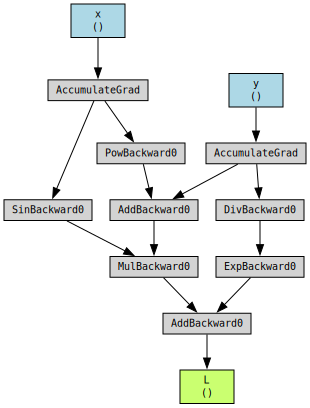


📐 Gradients (computed automatically via this graph!):
   ∂L/∂x = 0.7242
   ∂L/∂y = 3.1501


In [15]:
# ============================================================
# EXAMPLE 2: More Complex Graph with Multiple Operations
# ============================================================

if TORCH_AVAILABLE and TORCHVIZ_AVAILABLE:
    # Create inputs
    x = torch.tensor(2.0, requires_grad=True)
    y = torch.tensor(3.0, requires_grad=True)
    
    # Complex expression: L = (x² + y) * sin(x) + exp(y/2)
    z1 = x ** 2           # x²
    z2 = z1 + y           # x² + y
    z3 = torch.sin(x)     # sin(x)
    z4 = z2 * z3          # (x² + y) * sin(x)
    z5 = y / 2            # y/2
    z6 = torch.exp(z5)    # exp(y/2)
    L = z4 + z6           # final result
    
    # Visualize
    dot = make_dot(L, params={'x': x, 'y': y, 'L': L})
    dot.attr(rankdir='TB')  # Top to bottom
    dot.attr(size='10,10')
    
    print("Computation: L = (x² + y) × sin(x) + exp(y/2)")
    print(f"Inputs: x={x.item()}, y={y.item()}")
    print(f"Result: L={L.item():.4f}")
    print("\n📊 Computation Graph (notice how operations are tracked!):")
    display(dot)
    
    # Compute gradients
    L.backward()
    print(f"\n📐 Gradients (computed automatically via this graph!):")
    print(f"   ∂L/∂x = {x.grad.item():.4f}")
    print(f"   ∂L/∂y = {y.grad.item():.4f}")
else:
    print("Skipping - requires torch and torchviz")

Neural Network Architecture:
  Input(3) → Linear(4) → ReLU → Linear(2) → Output

Total parameters: 26

📊 Full Computation Graph of the Neural Network:


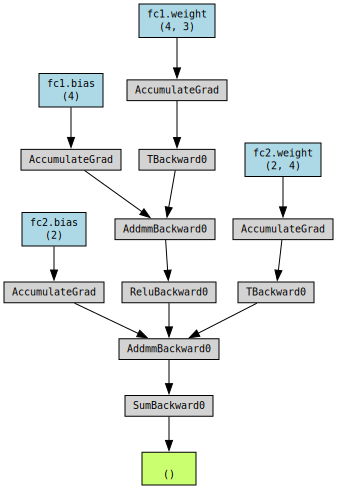


📌 Notice: Every operation is tracked!
   - Matrix multiplications (AddmmBackward)
   - Bias additions
   - ReLU activations (ReluBackward)
   - All connected to form the gradient flow path


In [16]:
# ============================================================
# EXAMPLE 3: Neural Network Computation Graph
# ============================================================

if TORCH_AVAILABLE and TORCHVIZ_AVAILABLE:
    import torch.nn as nn
    
    # Define a small neural network
    class TinyNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(3, 4)   # Input: 3 features, Hidden: 4 neurons
            self.fc2 = nn.Linear(4, 2)   # Hidden: 4 neurons, Output: 2 classes
            self.relu = nn.ReLU()
        
        def forward(self, x):
            x = self.fc1(x)
            x = self.relu(x)
            x = self.fc2(x)
            return x
    
    # Create model and input
    model = TinyNet()
    x_input = torch.randn(1, 3)  # Batch of 1, 3 features
    
    # Forward pass
    output = model(x_input)
    loss = output.sum()  # Dummy loss
    
    # Visualize the full computation graph
    dot = make_dot(loss, params=dict(model.named_parameters()))
    dot.attr(rankdir='TB')
    
    print("Neural Network Architecture:")
    print("  Input(3) → Linear(4) → ReLU → Linear(2) → Output")
    print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
    print("\n📊 Full Computation Graph of the Neural Network:")
    display(dot)
    
    print("\n📌 Notice: Every operation is tracked!")
    print("   - Matrix multiplications (AddmmBackward)")
    print("   - Bias additions")
    print("   - ReLU activations (ReluBackward)")
    print("   - All connected to form the gradient flow path")
else:
    print("Skipping - requires torch and torchviz")

Custom Computation Graph: L = (a + b) × (c + d)

🟢 Green = Inputs
🟡 Yellow = Operations
🔵 Blue = Intermediate values
🔴 Red = Output

📊 Graph:


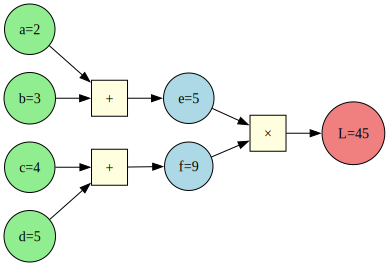

In [17]:
# ============================================================
# ALTERNATIVE: Manual Graph with Graphviz (no PyTorch needed)
# ============================================================

try:
    from graphviz import Digraph
    GRAPHVIZ_AVAILABLE = True
except ImportError:
    GRAPHVIZ_AVAILABLE = False
    print("⚠️ graphviz not installed. Run: pip install graphviz")

if GRAPHVIZ_AVAILABLE:
    # Create a custom computation graph diagram
    dot = Digraph(comment='Computation Graph')
    dot.attr(rankdir='LR', size='12,8')
    
    # Style settings
    dot.attr('node', shape='circle', style='filled')
    
    # Input nodes (green)
    with dot.subgraph() as s:
        s.attr(rank='same')
        s.node('a', 'a=2', fillcolor='lightgreen')
        s.node('b', 'b=3', fillcolor='lightgreen')
        s.node('c', 'c=4', fillcolor='lightgreen')
        s.node('d', 'd=5', fillcolor='lightgreen')
    
    # Operation nodes (yellow)
    dot.node('add1', '+', shape='square', fillcolor='lightyellow')
    dot.node('add2', '+', shape='square', fillcolor='lightyellow')
    dot.node('mul', '×', shape='square', fillcolor='lightyellow')
    
    # Intermediate nodes (blue)
    dot.node('e', 'e=5', fillcolor='lightblue')
    dot.node('f', 'f=9', fillcolor='lightblue')
    
    # Output node (red)
    dot.node('L', 'L=45', fillcolor='lightcoral')
    
    # Edges (forward pass)
    dot.edge('a', 'add1')
    dot.edge('b', 'add1')
    dot.edge('add1', 'e')
    
    dot.edge('c', 'add2')
    dot.edge('d', 'add2')
    dot.edge('add2', 'f')
    
    dot.edge('e', 'mul')
    dot.edge('f', 'mul')
    dot.edge('mul', 'L')
    
    print("Custom Computation Graph: L = (a + b) × (c + d)")
    print("\n🟢 Green = Inputs")
    print("🟡 Yellow = Operations")
    print("🔵 Blue = Intermediate values")
    print("🔴 Red = Output")
    print("\n📊 Graph:")
    display(dot)

FORWARD PASS: Computing L = (a + b) × (c + d)


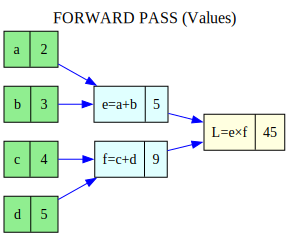


BACKWARD PASS: Computing Gradients via Chain Rule
Edge labels show the local derivative multiplied at each step


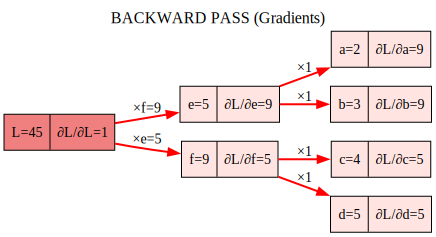


📌 Notice how gradients flow BACKWARD through the graph!
   Each node receives: (upstream gradient) × (local derivative)


In [18]:
# ============================================================
# FORWARD AND BACKWARD PASS VISUALIZATION
# ============================================================

if GRAPHVIZ_AVAILABLE:
    from graphviz import Digraph
    
    def create_pass_graph(is_backward=False):
        """Create graph showing forward or backward pass"""
        dot = Digraph()
        dot.attr(rankdir='LR', size='10,6')
        dot.attr('node', shape='record', style='filled')
        
        if is_backward:
            # Backward pass - show gradients
            dot.attr(label='BACKWARD PASS (Gradients)', labelloc='t', fontsize='16')
            color = 'mistyrose'
            edge_color = 'red'
            dot.node('a', '{a=2|∂L/∂a=9}', fillcolor=color)
            dot.node('b', '{b=3|∂L/∂b=9}', fillcolor=color)
            dot.node('c', '{c=4|∂L/∂c=5}', fillcolor=color)
            dot.node('d', '{d=5|∂L/∂d=5}', fillcolor=color)
            dot.node('e', '{e=5|∂L/∂e=9}', fillcolor=color)
            dot.node('f', '{f=9|∂L/∂f=5}', fillcolor=color)
            dot.node('L', '{L=45|∂L/∂L=1}', fillcolor='lightcoral')
            
            # Reversed edges for backward
            dot.edge('e', 'a', color=edge_color, style='bold', label='×1')
            dot.edge('e', 'b', color=edge_color, style='bold', label='×1')
            dot.edge('f', 'c', color=edge_color, style='bold', label='×1')
            dot.edge('f', 'd', color=edge_color, style='bold', label='×1')
            dot.edge('L', 'e', color=edge_color, style='bold', label='×f=9')
            dot.edge('L', 'f', color=edge_color, style='bold', label='×e=5')
        else:
            # Forward pass - show values
            dot.attr(label='FORWARD PASS (Values)', labelloc='t', fontsize='16')
            color = 'lightcyan'
            edge_color = 'blue'
            dot.node('a', '{a|2}', fillcolor='lightgreen')
            dot.node('b', '{b|3}', fillcolor='lightgreen')
            dot.node('c', '{c|4}', fillcolor='lightgreen')
            dot.node('d', '{d|5}', fillcolor='lightgreen')
            dot.node('e', '{e=a+b|5}', fillcolor=color)
            dot.node('f', '{f=c+d|9}', fillcolor=color)
            dot.node('L', '{L=e×f|45}', fillcolor='lightyellow')
            
            # Forward edges
            dot.edge('a', 'e', color=edge_color)
            dot.edge('b', 'e', color=edge_color)
            dot.edge('c', 'f', color=edge_color)
            dot.edge('d', 'f', color=edge_color)
            dot.edge('e', 'L', color=edge_color)
            dot.edge('f', 'L', color=edge_color)
        
        return dot
    
    print("="*70)
    print("FORWARD PASS: Computing L = (a + b) × (c + d)")
    print("="*70)
    display(create_pass_graph(is_backward=False))
    
    print("\n" + "="*70)
    print("BACKWARD PASS: Computing Gradients via Chain Rule")
    print("="*70)
    print("Edge labels show the local derivative multiplied at each step")
    display(create_pass_graph(is_backward=True))
    
    print("\n📌 Notice how gradients flow BACKWARD through the graph!")
    print("   Each node receives: (upstream gradient) × (local derivative)")

---

# Part 5: Forward Mode vs Reverse Mode

---

There are actually **two ways** to apply the chain rule automatically:

## 5.1 The Two Modes

| Mode | Direction | Computes | Best For |
|------|-----------|----------|----------|
| **Forward** | Input → Output | $\frac{\partial \text{all outputs}}{\partial \text{one input}}$ | Few inputs, many outputs |
| **Reverse** | Output → Input | $\frac{\partial \text{one output}}{\partial \text{all inputs}}$ | Many inputs, few outputs |

## 5.2 Why Deep Learning Uses Reverse Mode

Neural networks have:
- **Millions of inputs** (parameters)
- **One output** (the loss)

```
┌─────────────────────────────────────────────────────────────────────┐
│                                                                     │
│   FORWARD MODE:                                                     │
│   "For each input, trace forward to see how output changes"         │
│                                                                     │
│   θ₁ ──────────────────────────────────────────► ∂L/∂θ₁             │
│   θ₂ ──────────────────────────────────────────► (need another pass)│
│   θ₃ ──────────────────────────────────────────► (another pass...)  │
│   ...                                                               │
│   θₙ ──────────────────────────────────────────► (N passes total!)  │
│                                                                     │
│   Cost: O(N) passes for N parameters                                │
│                                                                     │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│   REVERSE MODE (BACKPROPAGATION):                                   │
│   "Start from output, trace backward to ALL inputs at once"         │
│                                                                     │
│   θ₁ ◄──┐                                                           │
│   θ₂ ◄──┤                                                           │
│   θ₃ ◄──┼─────────────────────────────────────────────────── L      │
│   ...   │     (one backward pass gives ALL gradients!)              │
│   θₙ ◄──┘                                                           │
│                                                                     │
│   Cost: O(1) passes regardless of N!                                │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

### This Is Why Backprop Exists!

Backpropagation **IS** reverse-mode automatic differentiation.

It was discovered multiple times in different fields before being applied to neural networks.

---

---

# Part 6: Building a Mini Autograd Engine

---

The best way to understand autodiff is to **build one yourself**.

Let's create a minimal but working autograd engine from scratch.

## 6.1 The Core Idea

We need a `Value` class that:
1. Stores data
2. Tracks which operation created it
3. Knows its parent nodes
4. Can compute local gradients

In [19]:
# ============================================================
# BUILDING A MINI AUTOGRAD FROM SCRATCH
# ============================================================

class Value:
    """
    A node in the computational graph.
    Stores a scalar value and its gradient.
    """
    
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0.0  # Gradient of final output w.r.t. this node
        
        # For building the graph
        self._backward = lambda: None  # Function to compute gradients
        self._prev = set(_children)    # Parent nodes
        self._op = _op                 # Operation that created this node
    
    def __repr__(self):
        return f"Value(data={self.data:.4f}, grad={self.grad:.4f})"
    
    # ─────────────────────────────────────────────────────────────
    # ADDITION
    # ─────────────────────────────────────────────────────────────
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            # d(a+b)/da = 1, d(a+b)/db = 1
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    # ─────────────────────────────────────────────────────────────
    # MULTIPLICATION
    # ─────────────────────────────────────────────────────────────
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            # d(a*b)/da = b, d(a*b)/db = a
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    # ─────────────────────────────────────────────────────────────
    # POWER
    # ─────────────────────────────────────────────────────────────
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            # d(x^n)/dx = n * x^(n-1)
            self.grad += other * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward
        return out
    
    # ─────────────────────────────────────────────────────────────
    # NEGATION AND SUBTRACTION
    # ─────────────────────────────────────────────────────────────
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    # Handle reversed operations (e.g., 2 * Value)
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other
    
    # ─────────────────────────────────────────────────────────────
    # BACKWARD PASS
    # ─────────────────────────────────────────────────────────────
    def backward(self):
        """
        Compute gradients for all nodes in the graph.
        Uses topological sort to ensure correct order.
        """
        # Build topological order
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        
        # Start with gradient 1 at output
        self.grad = 1.0
        
        # Apply chain rule in reverse order
        for node in reversed(topo):
            node._backward()

print("✅ Mini autograd engine built!")

✅ Mini autograd engine built!


In [20]:
# ============================================================
# TEST: Using our mini autograd
# ============================================================

print("="*70)
print("TESTING OUR MINI AUTOGRAD")
print("="*70)

# Create input values
a = Value(2.0)
b = Value(3.0)
c = Value(4.0)
d = Value(5.0)

print(f"\nInputs: a={a.data}, b={b.data}, c={c.data}, d={d.data}")

# Compute: L = (a + b) * (c + d)
e = a + b        # e = 5
f = c + d        # f = 9  
L = e * f        # L = 45

print(f"\nForward pass: L = (a + b) × (c + d) = ({a.data} + {b.data}) × ({c.data} + {d.data}) = {L.data}")

# Backward pass
L.backward()

print("\n" + "─"*70)
print("GRADIENTS (computed by our engine):")
print("─"*70)
print(f"  ∂L/∂a = {a.grad}  (expected: c+d = 9) {'✓' if a.grad == 9 else '✗'}")
print(f"  ∂L/∂b = {b.grad}  (expected: c+d = 9) {'✓' if b.grad == 9 else '✗'}")
print(f"  ∂L/∂c = {c.grad}  (expected: a+b = 5) {'✓' if c.grad == 5 else '✗'}")
print(f"  ∂L/∂d = {d.grad}  (expected: a+b = 5) {'✓' if d.grad == 5 else '✗'}")

print("\n🎉 It works! We built automatic differentiation from scratch!")

TESTING OUR MINI AUTOGRAD

Inputs: a=2.0, b=3.0, c=4.0, d=5.0

Forward pass: L = (a + b) × (c + d) = (2.0 + 3.0) × (4.0 + 5.0) = 45.0

──────────────────────────────────────────────────────────────────────
GRADIENTS (computed by our engine):
──────────────────────────────────────────────────────────────────────
  ∂L/∂a = 9.0  (expected: c+d = 9) ✓
  ∂L/∂b = 9.0  (expected: c+d = 9) ✓
  ∂L/∂c = 5.0  (expected: a+b = 5) ✓
  ∂L/∂d = 5.0  (expected: a+b = 5) ✓

🎉 It works! We built automatic differentiation from scratch!


In [21]:
# ============================================================
# MORE COMPLEX EXAMPLE
# ============================================================

print("\n" + "="*70)
print("MORE COMPLEX EXAMPLE: L = (x² + y)³")
print("="*70)

x = Value(2.0)
y = Value(3.0)

# Compute L = (x² + y)³
z = x**2 + y    # z = 4 + 3 = 7
L = z**3        # L = 343

print(f"\nInputs: x={x.data}, y={y.data}")
print(f"Forward: L = (x² + y)³ = ({x.data}² + {y.data})³ = {L.data}")

# Backward
L.backward()

# Analytical gradients:
# L = (x² + y)³
# ∂L/∂x = 3(x² + y)² × 2x = 6x(x² + y)² = 6 × 2 × 49 = 588
# ∂L/∂y = 3(x² + y)² × 1 = 3 × 49 = 147

expected_dx = 6 * x.data * (x.data**2 + y.data)**2
expected_dy = 3 * (x.data**2 + y.data)**2

print("\n" + "─"*70)
print("GRADIENTS:")
print("─"*70)
print(f"  ∂L/∂x = {x.grad}  (expected: {expected_dx}) {'✓' if abs(x.grad - expected_dx) < 1e-6 else '✗'}")
print(f"  ∂L/∂y = {y.grad}  (expected: {expected_dy}) {'✓' if abs(y.grad - expected_dy) < 1e-6 else '✗'}")


MORE COMPLEX EXAMPLE: L = (x² + y)³

Inputs: x=2.0, y=3.0
Forward: L = (x² + y)³ = (2.0² + 3.0)³ = 343.0

──────────────────────────────────────────────────────────────────────
GRADIENTS:
──────────────────────────────────────────────────────────────────────
  ∂L/∂x = 588.0  (expected: 588.0) ✓
  ∂L/∂y = 147.0  (expected: 147.0) ✓


## 6.2 What We Built vs Real Libraries

| Feature | Our Mini Engine | PyTorch/TensorFlow |
|---------|----------------|--------------------|
| Basic ops (+, *, **) | ✓ | ✓ |
| Scalars | ✓ | ✓ |
| Tensors (matrices) | ✗ | ✓ |
| GPU support | ✗ | ✓ |
| Optimized kernels | ✗ | ✓ |
| Neural network layers | ✗ | ✓ |
| Memory optimization | ✗ | ✓ |

**But the core idea is identical!**

---

---

# Part 7: Real Libraries — PyTorch, TensorFlow, JAX

---

Now that we understand how autodiff works, let's see how real libraries do it.

## 7.1 PyTorch: Dynamic Graphs with `autograd`

PyTorch builds the graph **as you compute** (eager execution).

In [22]:
# ============================================================
# PYTORCH AUTOGRAD
# ============================================================

if TORCH_AVAILABLE:
    print("="*70)
    print("PYTORCH AUTOGRAD")
    print("="*70)
    
    # Create tensors with gradient tracking
    x = torch.tensor(2.0, requires_grad=True)
    y = torch.tensor(3.0, requires_grad=True)
    
    print(f"\nInputs: x = {x.item()}, y = {y.item()}")
    print("Computing: L = (x² + y)³")
    
    # Forward pass (graph is built automatically)
    z = x**2 + y
    L = z**3
    
    print(f"Result: L = {L.item()}")
    
    # Backward pass
    L.backward()
    
    print(f"\nGradients:")
    print(f"  x.grad = {x.grad.item()}  (∂L/∂x)")
    print(f"  y.grad = {y.grad.item()}  (∂L/∂y)")
    
    print("\n" + "─"*70)
    print("KEY PYTORCH PATTERNS:")
    print("─"*70)
    print("""
    1. requires_grad=True  → Track this tensor for gradients
    2. loss.backward()     → Compute all gradients
    3. tensor.grad         → Access the gradient
    4. optimizer.zero_grad() → Clear gradients before next iteration
    """)
else:
    print("PyTorch not available")

PYTORCH AUTOGRAD

Inputs: x = 2.0, y = 3.0
Computing: L = (x² + y)³
Result: L = 343.0

Gradients:
  x.grad = 588.0  (∂L/∂x)
  y.grad = 147.0  (∂L/∂y)

──────────────────────────────────────────────────────────────────────
KEY PYTORCH PATTERNS:
──────────────────────────────────────────────────────────────────────

    1. requires_grad=True  → Track this tensor for gradients
    2. loss.backward()     → Compute all gradients
    3. tensor.grad         → Access the gradient
    4. optimizer.zero_grad() → Clear gradients before next iteration
    


In [23]:
# ============================================================
# PRACTICAL PATTERN: Training Loop with PyTorch
# ============================================================

if TORCH_AVAILABLE:
    print("="*70)
    print("PRACTICAL EXAMPLE: Simple Linear Regression with Autograd")
    print("="*70)
    
    # Generate data: y = 3x + 2 + noise
    torch.manual_seed(42)
    X = torch.linspace(0, 10, 100).reshape(-1, 1)
    y_true = 3 * X + 2 + torch.randn_like(X) * 0.5
    
    # Parameters (what we're learning)
    w = torch.tensor([0.0], requires_grad=True)
    b = torch.tensor([0.0], requires_grad=True)
    
    learning_rate = 0.01
    
    print(f"\nTrue parameters: w=3, b=2")
    print(f"Initial parameters: w={w.item():.4f}, b={b.item():.4f}")
    print("\nTraining...")
    
    for epoch in range(100):
        # Forward pass
        y_pred = w * X + b
        loss = ((y_pred - y_true) ** 2).mean()  # MSE
        
        # Backward pass (autograd computes gradients!)
        loss.backward()
        
        # Update parameters (manually for clarity)
        with torch.no_grad():
            w -= learning_rate * w.grad
            b -= learning_rate * b.grad
        
        # Zero gradients for next iteration
        w.grad.zero_()
        b.grad.zero_()
        
        if epoch % 20 == 0:
            print(f"  Epoch {epoch:3d}: Loss = {loss.item():.4f}, w = {w.item():.4f}, b = {b.item():.4f}")
    
    print(f"\nFinal: w = {w.item():.4f} (true: 3), b = {b.item():.4f} (true: 2)")
    print("\n✅ Autograd computed all gradients automatically!")

PRACTICAL EXAMPLE: Simple Linear Regression with Autograd

True parameters: w=3, b=2
Initial parameters: w=0.0000, b=0.0000

Training...
  Epoch   0: Loss = 366.6225, w = 2.2126, b = 0.3406
  Epoch  20: Loss = 0.7461, w = 3.2082, b = 0.6405
  Epoch  40: Loss = 0.6549, w = 3.1882, b = 0.7736
  Epoch  60: Loss = 0.5801, w = 3.1701, b = 0.8940
  Epoch  80: Loss = 0.5189, w = 3.1537, b = 1.0030

Final: w = 3.1395 (true: 3), b = 1.0970 (true: 2)

✅ Autograd computed all gradients automatically!


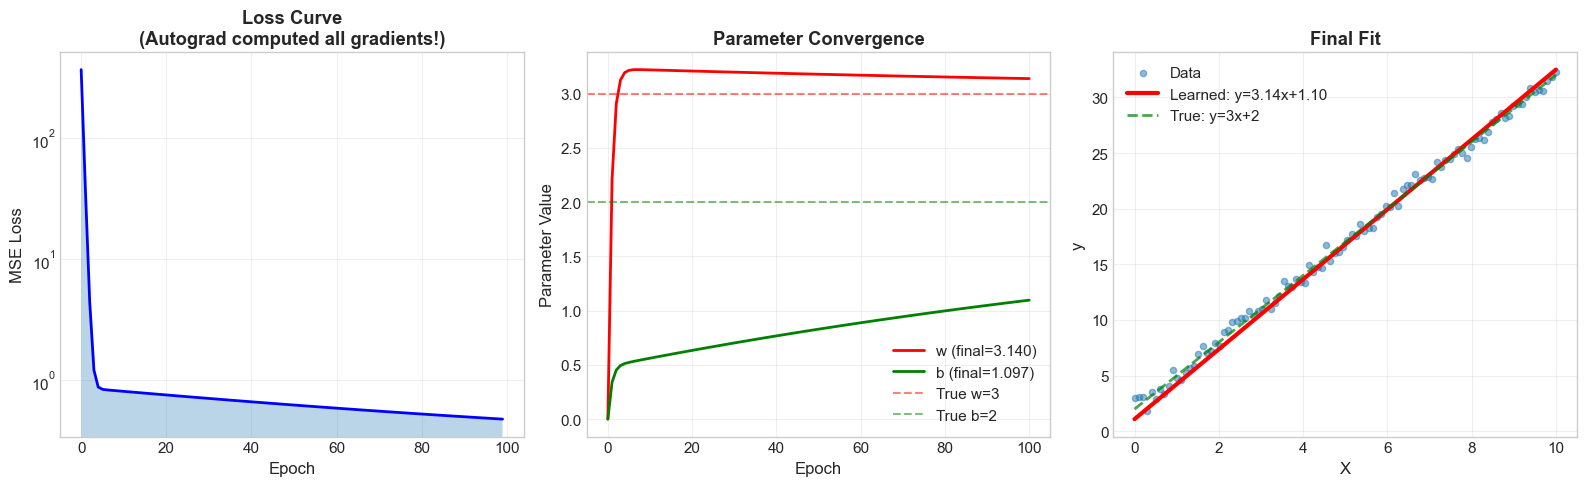


📌 KEY POINT: We never manually computed a single gradient!
   PyTorch's autograd did ALL the calculus for us.


In [24]:
# ============================================================
# VISUALIZATION: Training Progress
# ============================================================

if TORCH_AVAILABLE:
    # Re-run training with history tracking
    torch.manual_seed(42)
    X = torch.linspace(0, 10, 100).reshape(-1, 1)
    y_true = 3 * X + 2 + torch.randn_like(X) * 0.5
    
    w = torch.tensor([0.0], requires_grad=True)
    b = torch.tensor([0.0], requires_grad=True)
    learning_rate = 0.01
    
    # Track history
    loss_history = []
    w_history = [w.item()]
    b_history = [b.item()]
    
    for epoch in range(100):
        y_pred = w * X + b
        loss = ((y_pred - y_true) ** 2).mean()
        loss.backward()
        
        with torch.no_grad():
            w -= learning_rate * w.grad
            b -= learning_rate * b.grad
        
        w.grad.zero_()
        b.grad.zero_()
        
        loss_history.append(loss.item())
        w_history.append(w.item())
        b_history.append(b.item())
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Plot 1: Loss curve
    ax1 = axes[0]
    ax1.plot(loss_history, 'b-', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('MSE Loss', fontsize=12)
    ax1.set_title('Loss Curve\n(Autograd computed all gradients!)', fontweight='bold')
    ax1.fill_between(range(len(loss_history)), loss_history, alpha=0.3)
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Parameter evolution
    ax2 = axes[1]
    ax2.plot(w_history, 'r-', linewidth=2, label=f'w (final={w_history[-1]:.3f})')
    ax2.plot(b_history, 'g-', linewidth=2, label=f'b (final={b_history[-1]:.3f})')
    ax2.axhline(y=3, color='r', linestyle='--', alpha=0.5, label='True w=3')
    ax2.axhline(y=2, color='g', linestyle='--', alpha=0.5, label='True b=2')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Parameter Value', fontsize=12)
    ax2.set_title('Parameter Convergence', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Data fit
    ax3 = axes[2]
    ax3.scatter(X.numpy(), y_true.numpy(), alpha=0.5, s=20, label='Data')
    ax3.plot(X.numpy(), (w * X + b).detach().numpy(), 'r-', linewidth=3, label=f'Learned: y={w.item():.2f}x+{b.item():.2f}')
    ax3.plot(X.numpy(), (3 * X + 2).numpy(), 'g--', linewidth=2, alpha=0.7, label='True: y=3x+2')
    ax3.set_xlabel('X', fontsize=12)
    ax3.set_ylabel('y', fontsize=12)
    ax3.set_title('Final Fit', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📌 KEY POINT: We never manually computed a single gradient!")
    print("   PyTorch's autograd did ALL the calculus for us.")

## 7.2 Comparison: Different Library APIs

Here's how the same gradient computation looks in different libraries:

```python
# ═══════════════════════════════════════════════════════════════
# PYTORCH
# ═══════════════════════════════════════════════════════════════
import torch

x = torch.tensor(2.0, requires_grad=True)
y = x ** 2 + 3 * x
y.backward()
print(x.grad)  # 2*x + 3 = 7

# ═══════════════════════════════════════════════════════════════
# TENSORFLOW 2.x (GradientTape)
# ═══════════════════════════════════════════════════════════════
import tensorflow as tf

x = tf.Variable(2.0)
with tf.GradientTape() as tape:
    y = x ** 2 + 3 * x
grad = tape.gradient(y, x)
print(grad)  # 7.0

# ═══════════════════════════════════════════════════════════════
# JAX (Functional style)
# ═══════════════════════════════════════════════════════════════
import jax
import jax.numpy as jnp

def f(x):
    return x ** 2 + 3 * x

grad_f = jax.grad(f)
print(grad_f(2.0))  # 7.0

# ═══════════════════════════════════════════════════════════════
# AUTOGRAD (Standalone, NumPy-compatible)
# ═══════════════════════════════════════════════════════════════
import autograd.numpy as np
from autograd import grad

def f(x):
    return x ** 2 + 3 * x

grad_f = grad(f)
print(grad_f(2.0))  # 7.0
```

### Quick Comparison

| Library | Graph Type | API Style | Best For |
|---------|-----------|-----------|----------|
| **PyTorch** | Dynamic | Object-oriented | Research, flexibility |
| **TensorFlow** | Dynamic (2.x) | Context manager | Production, deployment |
| **JAX** | Functional | Composable transforms | Research, TPUs |
| **Autograd** | Dynamic | Functional | Learning, small projects |

---

# Part 8: Common Gotchas and Debugging

---

## 8.1 Common Mistakes

| Problem | Symptom | Solution |
|---------|---------|----------|
| **Forgot `requires_grad`** | `.grad` is `None` | Add `requires_grad=True` |
| **In-place operations** | RuntimeError | Use `x = x + 1` not `x += 1` |
| **Gradient accumulation** | Gradients too large | Call `optimizer.zero_grad()` |
| **Non-differentiable op** | Gradient is 0 or None | Use smooth approximation |
| **Detached tensor** | Gradient doesn't flow | Don't use `.detach()` mid-graph |
| **Double backward** | Error on second `.backward()` | Use `retain_graph=True` |

## 8.2 Debugging Tips

```python
# Check if gradient is being tracked
print(tensor.requires_grad)  # Should be True
print(tensor.grad_fn)        # Should show the operation, not None

# Check gradient values
loss.backward()
for name, param in model.named_parameters():
    if param.grad is None:
        print(f"WARNING: {name} has no gradient!")
    elif param.grad.abs().max() > 1000:
        print(f"WARNING: {name} has exploding gradient!")
    elif param.grad.abs().max() < 1e-7:
        print(f"WARNING: {name} has vanishing gradient!")
```

---

---

# 🎓 Summary: What You've Learned

---

## The Big Picture

| Concept | Key Takeaway |
|---------|-------------|
| **Manual gradients** | Don't scale beyond simple functions |
| **Numerical differentiation** | Approximate, slow, numerically unstable |
| **Autodiff** | Exact, fast, scales to billions of parameters |
| **Computational graph** | Records operations for replay |
| **Forward mode** | Good for few inputs, many outputs |
| **Reverse mode** | Good for many inputs, few outputs (= deep learning!) |
| **Backpropagation** | IS reverse-mode autodiff |

## The Critical Distinction

```
┌─────────────────────────────────────────────────────────────────────┐
│                                                                     │
│   NUMERICAL: Approximates derivatives by wiggling inputs           │
│              → Slow (O(N) passes)                                   │
│              → Approximate (finite h)                               │
│              → Unstable (floating point)                            │
│                                                                     │
│   AUTODIFF:  Computes exact derivatives via chain rule             │
│              → Fast (O(1) backward pass)                            │
│              → Exact (to machine precision)                         │
│              → Stable (no h to tune)                                │
│                                                                     │
│   THEY ARE FUNDAMENTALLY DIFFERENT ALGORITHMS!                      │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

## Your Action Items

1. ✅ Understand that `.backward()` uses the chain rule, not approximation
2. ✅ Know that reverse-mode autodiff = backpropagation
3. ✅ Use `requires_grad=True` to track tensors
4. ✅ Call `optimizer.zero_grad()` before each backward pass
5. ✅ Debug with `.grad_fn` and gradient checks

---

*Now you understand the engine that powers all of modern deep learning!* 🚀